# Model Training


In [1]:
%matplotlib inline
from IPython.core.display import set_matplotlib_formats
import matplotlib
import matplotlib.pyplot as plt
import zipfile
import fnmatch
import os.path
import random
import shutil
import pandas as pd
import numpy as np
import os
import json
import gc
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense, Flatten, Dropout
from sklearn import metrics
from tensorflow.keras import backend as k
from tensorflow.keras.callbacks import Callback
from tensorflow import keras
import tensorflow as tf
import keras_tuner as kt
from common.model_utils import model_selection, build_model, input_size

# import packages and modules for graph plotting
from pandas.plotting import table

# setup output image format (Chrome works best)
set_matplotlib_formats("svg")

class ClearMemory(Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()
        k.clear_session()

/var/folders/6n/_1k_wx3s2fg5c_7xkb973_4h0000gn/T/ipykernel_10698/2145379285.py:31: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats("svg")


In [2]:
if tf.test.is_gpu_available():
    print("GPU is available and in use.")
else:
    print("No GPU found, using CPU.")

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU is available and in use.


2024-01-14 10:21:06.494584: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2024-01-14 10:21:06.494609: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-01-14 10:21:06.494617: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-01-14 10:21:06.494858: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-14 10:21:06.494875: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Create necessary project folders


In [3]:
# Input list of folder names
models_folder = "Benchmark Models"
history_folder = "History"
result_folder = "Result"
tuning_folder = "Tuning"
data_folder = "Training Data"
folder_names = [models_folder, history_folder, result_folder, tuning_folder]

for folder_name in folder_names:
    folder_path = os.path.join(".", folder_name)
    try:
        os.mkdir(folder_path)
        print(f"Folder '{folder_name}' created at {folder_path}")
    except FileExistsError:
        print(f"Folder '{folder_name}' already exists at {folder_path}")

Folder 'Benchmark Models' already exists at ./Benchmark Models
Folder 'History' already exists at ./History
Folder 'Result' already exists at ./Result
Folder 'Tuning' already exists at ./Tuning


In [4]:
# Split Data
# ├── Test
# │   ├── manipulated
# │   └── original
# ├── Training
# │   ├── manipulated
# │   └── original
# └── Validation
#     ├── manipulated
#     └── original

# Check if the dataset directory is already present to avoid redundant read and writes
isExist = os.path.exists("./" + data_folder + "/")

if not isExist:
    # Creates the appropriate directory structures for training, validation and test sets.
    try:
        shutil.rmtree("./" + data_folder + "/")
    except:
        pass  # Split Data didn't exist

    os.mkdir("./Split Data")
    cdf = {
        "Training": 0.7,
        "Validation": 0.85,
        "Test": 1,
    }  # OBS! Has to be increment percentages of 5 to make batch size fit
    for dir in list(cdf.keys()):
        os.mkdir("./" + data_folder + "/{}".format(dir))
        os.mkdir("./" + data_folder + "/{}/manipulated".format(dir))
        os.mkdir("./" + data_folder + "/{}/original".format(dir))
else:
    print("Dataset directory already exists!")

Dataset directory already exists!


## Models we want to train


In [5]:
model_list = [
    "EfficientNetB0",
    "EfficientNetB1",
    "EfficientNetB2",
    "EfficientNetB3",
]

models = {}
for model_type in model_list:
    size = input_size(model_type)
    models[model_type] = build_model(model_type, (size, size, 3))

2024-01-14 10:21:06.510496: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-14 10:21:06.510511: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 1280)              4049571   
 )                                                               
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
 dense_1 (Dense)             (None, 2)                 6         
                                                                 
Total params: 4052139 (15.46 MB)
Trainable params: 4010116 (15.30 MB)
Non-trainable params: 42023 (164.16 KB)
_________________________________________________________________


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb1 (Functional  (None, 1280)              6575239   
 )                                                               
                                                                 
 flatten_1 (Flatten)         (None, 1280)              0         
                                                                 
 dense_2 (Dense)             (None, 2)                 2562      
                                                                 
 dense_3 (Dense)             (None, 2)                 6         
                                                                 
Total params: 6577807 (25.09 MB)
Trainable params: 6515752 (24.86 MB)
Non-trainable params: 62055 (242.41 KB)
_________________________________________________________________


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb2 (Functional  (None, 1408)              7768569   
 )                                                               
                                                                 
 flatten_2 (Flatten)         (None, 1408)              0         
                                                                 
 dense_4 (Dense)             (None, 2)                 2818      
                                                                 
 dense_5 (Dense)             (None, 2)                 6         
                                                                 
Total params: 7771393 (29.65 MB)
Trainable params: 7703818 (29.39 MB)
Non-trainable params: 67575 (263.97 KB)
_________________________________________________________________


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional  (None, 1536)              10783535  
 )                                                               
                                                                 
 flatten_3 (Flatten)         (None, 1536)              0         
                                                                 
 dense_6 (Dense)             (None, 2)                 3074      
                                                                 
 dense_7 (Dense)             (None, 2)                 6         
                                                                 
Total params: 10786615 (41.15 MB)
Trainable params: 10699312 (40.81 MB)
Non-trainable params: 87303 (341.03 KB)
_________________________________________________________________


### Training the models

In [8]:
from tensorflow.keras.applications import efficientnet as efn

# Specify the path to the train and validation data
trainpath = os.path.join(".", data_folder, "Training")
valpath = os.path.join(".", data_folder, "Validation")

# constant fields
BATCH_SIZE = 16
EPOCHS = 20

models_fit_history = {}
models_result = {}
models_failed = []

# Train the models
for model_type in model_list:
    error_flag = False
    imgsize = input_size(model_type)

    # Check if the model is already trained to avoid redundant processing
    if not os.path.exists(os.path.join(".", models_folder, model_type + ".hdf5")):
        # Load data and preprocess it
        train_datagen = ImageDataGenerator(
            preprocessing_function=efn.preprocess_input
        )

        train_gen = train_datagen.flow_from_directory(
            trainpath,
            target_size=(imgsize, imgsize),
            batch_size=BATCH_SIZE,
            class_mode="categorical",
        )
        val_gen = train_datagen.flow_from_directory(
            valpath,
            target_size=(imgsize, imgsize),
            batch_size=BATCH_SIZE,
            class_mode="categorical",
        )

        # load model
        model = models[model_type]
        model.summary()

        # callbacks for early stopping and saving the best model so far based on validation loss for each epoch
        cb_early_stopper = EarlyStopping(monitor="val_loss", patience=5)
        cb_checkpointer = ModelCheckpoint(
            filepath=os.path.join(".", models_folder, model_type + ".hdf5"),
            monitor="val_loss",
            save_best_only=True,
            mode="auto",
        )

        try:
            # train model
            fit_history = model.fit(
                train_gen,
                epochs=EPOCHS,
                validation_data=val_gen,
                callbacks=[
                    cb_checkpointer,
                    cb_early_stopper,
                    ClearMemory(),
                ],  # ClearMemory() is a custom callback to clear memory after each epoch to avoid memory leak
            )

            models_fit_history[model_type] = fit_history
        except Exception as e:
            models_failed.append(model_type)
            error_flag = True
            print("Encountered error while training:", e)

        history_df = pd.DataFrame(models_fit_history[model_type].history)
        os.path.join(".", history_folder, model_type + ".hdf5")
        history_df.to_csv(
            os.path.join(".", history_folder, model_type + "_history.csv"), index=False
        )

    # Load the model from disk if it is already trained
    else:
        imgsize = input_size(model_type)
        model = build_model(model_type, (imgsize, imgsize, 3))
        model_path = os.path.join(".", models_folder, model_type + ".hdf5")
        model.load_weights(model_path)
        print("Loaded model {} from disk".format(model_type))

    # Skip testing if there was an error in training the model
    if error_flag:
        continue

    gc.collect()
    k.clear_session()

if len(models_failed) == 0:
    print("Models that failed training:")
    for fail in models_failed:
        print("\t" + fail)
else:
    print("All models have been initialised!")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 1280)              4049571   
 )                                                               
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
 dense_1 (Dense)             (None, 2)                 6         
                                                                 
Total params: 4052139 (15.46 MB)
Trainable params: 4010116 (15.30 MB)
Non-trainable params: 42023 (164.16 KB)
_________________________________________________________________


Loaded model EfficientNetB0 from disk
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb1 (Functional  (None, 1280)              6575239   
 )                                                               
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
 dense_1 (Dense)             (None, 2)                 6         
                                                                 
Total params: 6577807 (25.09 MB)
Trainable params: 6515752 (24.86 MB)
Non-trainable params: 62055 (242.41 KB)
_________________________________________________________________


Loaded model EfficientNetB1 from disk
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb2 (Functional  (None, 1408)              7768569   
 )                                                               
                                                                 
 flatten (Flatten)           (None, 1408)              0         
                                                                 
 dense (Dense)               (None, 2)                 2818      
                                                                 
 dense_1 (Dense)             (None, 2)                 6         
                                                                 
Total params: 7771393 (29.65 MB)
Trainable params: 7703818 (29.39 MB)
Non-trainable params: 67575 (263.97 KB)
_________________________________________________________________


Loaded model EfficientNetB2 from disk
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional  (None, 1536)              10783535  
 )                                                               
                                                                 
 flatten (Flatten)           (None, 1536)              0         
                                                                 
 dense (Dense)               (None, 2)                 3074      
                                                                 
 dense_1 (Dense)             (None, 2)                 6         
                                                                 
Total params: 10786615 (41.15 MB)
Trainable params: 10699312 (40.81 MB)
Non-trainable params: 87303 (341.03 KB)
_________________________________________________________________


Loaded model EfficientNetB3 from disk
Models that failed training:


In [10]:
# Specify the path to the test data
test_path = os.path.join(".", data_folder, "Test")

# Test the models
for model_type in model_list:
    print("Starting prediction for", model_type)
    test_img_gen = ImageDataGenerator(
        preprocessing_function=efn.preprocess_input
    )

    imgsize = input_size(model_type)

    test_generator = test_img_gen.flow_from_directory(
        directory=test_path,
        target_size=(imgsize, imgsize),
        batch_size=BATCH_SIZE,
        class_mode=None,
        shuffle=False,
        seed=123,
    )

    model = build_model(model_type,(imgsize, imgsize, 3))
    model_path = os.path.join(".", models_folder, model_type + ".hdf5")
    model.load_weights(model_path)
    print("Loaded model {} from disk".format(model_type))

    predicted = model.predict(test_generator, steps=len(test_generator), verbose=1)
    predicted_class_indices = np.argmax(predicted, axis=1)
    y = test_generator.classes

    Accuracy = metrics.accuracy_score(y, predicted_class_indices)
    print("Model Accuracy: ", Accuracy)

    Precision = metrics.precision_score(y, predicted_class_indices, average="binary")
    print("Model Precision: ", Precision)

    Recall = metrics.recall_score(y, predicted_class_indices, average="binary")
    print("Model Recall: ", Recall)

    Auc = metrics.roc_auc_score(y, predicted_class_indices)
    print("AUC: ", Auc, "\n")

    models_result[model_type] = {
        "Accuracy": Accuracy,
        "Precision": Precision,
        "Recall": Recall,
        "AUC": Auc,
    }

    filenames = [os.path.split(i)[1] for i in test_generator.filenames]
    actualLabel = [os.path.split(i)[0] for i in test_generator.filenames]

    for i in range(len(actualLabel)):
        if actualLabel[i] == "manipulated":
            actualLabel[i] = "0"
        else:
            actualLabel[i] = "1"
    results_df = pd.DataFrame(
        {
            "id": pd.Series(filenames),
            "actual label": pd.Series(actualLabel),
            "pred label": pd.Series(predicted_class_indices),
        }
    )
    os.makedirs(result_folder, exist_ok=True)
    results_df.to_csv(os.path.join(".", result_folder, model_type + "_out.csv"))

with open(os.path.join(".", result_folder, "model_results.json"), "w") as outfile:
    json.dump(models_result, outfile)

model_prediction_results = pd.DataFrame.from_dict(models_result, orient="index")
model_prediction_results.to_csv(
    os.path.join(".", result_folder, "prediction_results.csv")
)

Starting prediction for EfficientNetB0
Found 42562 images belonging to 2 classes.
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 1280)              4049571   
 )                                                               
                                                                 
 flatten_1 (Flatten)         (None, 1280)              0         
                                                                 
 dense_2 (Dense)             (None, 2)                 2562      
                                                                 
 dense_3 (Dense)             (None, 2)                 6         
                                                                 
Total params: 4052139 (15.46 MB)
Trainable params: 4010116 (15.30 MB)
Non-trainable params: 42023 (164.16 KB)
____________________________________________________________

Loaded model EfficientNetB0 from disk


2024-01-14 10:54:51.100393: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2661/2661 [==============================] - 84s 31ms/step
Model Accuracy:  0.966895352661999
Model Precision:  0.9454007530930608
Model Recall:  0.9910248578544242
AUC:  0.9668953526619991 

Starting prediction for EfficientNetB1
Found 42562 images belonging to 2 classes.
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb1 (Functional  (None, 1280)              6575239   
 )                                                               
                                                                 
 flatten_2 (Flatten)         (None, 1280)              0         
                                                                 
 dense_4 (Dense)             (None, 2)                 2562      
                                                                 
 dense_5 (Dense)             (None, 2)                 6         
                                            

Loaded model EfficientNetB1 from disk


2024-01-14 10:56:18.439930: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2661/2661 [==============================] - 134s 50ms/step
Model Accuracy:  0.9776561251820873
Model Precision:  0.9632245716368939
Model Recall:  0.993233400686058
AUC:  0.9776561251820873 

Starting prediction for EfficientNetB2
Found 42562 images belonging to 2 classes.
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb2 (Functional  (None, 1408)              7768569   
 )                                                               
                                                                 
 flatten_3 (Flatten)         (None, 1408)              0         
                                                                 
 dense_6 (Dense)             (None, 2)                 2818      
                                                                 
 dense_7 (Dense)             (None, 2)                 6         
                                           

Loaded model EfficientNetB2 from disk


2024-01-14 10:58:36.274729: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2661/2661 [==============================] - 184s 68ms/step
Model Accuracy:  0.9744137963441568
Model Precision:  0.9671478808069591
Model Recall:  0.9821906865278888
AUC:  0.9744137963441568 

Starting prediction for EfficientNetB3
Found 42562 images belonging to 2 classes.
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional  (None, 1536)              10783535  
 )                                                               
                                                                 
 flatten_4 (Flatten)         (None, 1536)              0         
                                                                 
 dense_8 (Dense)             (None, 2)                 3074      
                                                                 
 dense_9 (Dense)             (None, 2)                 6         
                                          

Loaded model EfficientNetB3 from disk


2024-01-14 11:01:44.459959: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2661/2661 [==============================] - 316s 118ms/step
Model Accuracy:  0.9788543771439312
Model Precision:  0.9673469387755103
Model Recall:  0.9911658286734646
AUC:  0.9788543771439312 



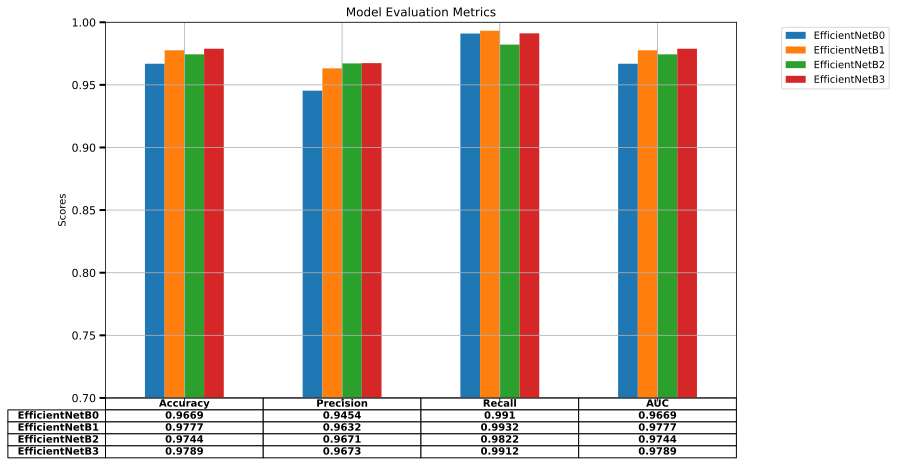

In [11]:
# creating a 2 dimensional dataframe out of the given data
results_df = pd.read_csv(os.path.join(".", result_folder, "prediction_results.csv"))
results_df = results_df.rename(columns={"Unnamed: 0": "Model"})


# Set the model names as the index for better labeling on the x-axis
results_df.set_index("Model", inplace=True)

results_df_transposed = results_df.transpose()

# Create a bar plot for the DataFrame
ax = results_df_transposed.plot(kind="bar", figsize=(12, 8))
ax.set_ylabel("Scores")
# ax.set_xlabel('Metrics')
ax.set_title("Model Evaluation Metrics")

# Set the y-axis lower limit to 0.90
ax.set_ylim(0.70, 1.0)
ax.legend(loc="upper right", bbox_to_anchor=(1.25, 1), ncol=1)

# Show the plot
plt.grid()

# Bold the fonts in the graph
matplotlib.rcParams["font.weight"] = "bold"
matplotlib.rcParams["axes.labelweight"] = "bold"
matplotlib.rcParams["axes.titleweight"] = "bold"
ax.tick_params(axis="y", which="major", labelsize=11, width=2, length=6)

# plt.xticks(rotation=45)
ax.set_xticklabels([])
plt.tight_layout()
plt.subplots_adjust(bottom=0.3)
table(ax, results_df.round(4), loc="bottom", cellLoc="center")
plt.show()